In [1]:
from __future__ import print_function
from matplotlib.patches import Ellipse

import matplotlib.pyplot as plt
import tables as tb
import numpy  as np

%matplotlib inline

generate_training_data = True
Compare_with_MC = True
Compare_NN_predictions = False #  Note if not compare w/ MC, this is irrelevant 

Generate some random events in EL plane

In [2]:
def gen_polar_hits(num, N_ELpts, EL_radius):
    """
    Generate hits in polar coordinates. Using polar coords for convenience, since hits must
    be within EL radius
    """
    yp_  = np.empty((num,N_ELpts*2), np.float32)
    yp_[:,0:N_ELpts]         = np.random.uniform(0,EL_radius,(num, N_ELpts))
    yp_[:,N_ELpts:2*N_ELpts] = np.random.uniform(0,2*np.pi,  (num,N_ELpts))
    return yp_

def cartesian_convert(r, theta, N_ELpts):
    """
    Convert polar coords to cartesian
    """
    yc_ = np.empty((r.shape[0],r.shape[1]*2),np.float32)
    for i in range(N_ELpts):
        yc_[:,i]           = np.cos(theta[:,i])*r[:,i] # xcoords
        yc_[:,N_ELpts + i] = np.sin(theta[:,i])*r[:,i] # ycoords
    return yc_

Open light table

In [3]:
f        = tb.open_file('ReproducedFull.h5', 'r')
table    = f.root.Probabilities.data
print(table.description)

Description([('grid_xy', '(2,)f4'), ('sens_id', '(1,)i4'), ('sens_prob', '(1,)f4')])


In [4]:
grid   = np.array(table[:]['grid_xy'  ], dtype=np.int)
probs  = np.array(table[:]['sens_prob'], dtype=np.float32)
ids    = np.array(table[:]['sens_id'  ], dtype=np.int)
id_pos = np.array(f.root.Sensors.XY[12:])

# Note: table.where does not support condition with multidim col (and cant simply index into multidim col)
#test = np.array([[row['sens_id'],row['probs']] for row in table.where("grid_xy[0] == coords[0,0] & grid_xy[1] == coords[0,1]")])

# so, replace ids with positions **takes 30 seconds**
pos = np.ones((len(ids),2), dtype=np.int)*-9999 # -9999 will correspond to PMTs
for p in id_pos: pos[np.where(ids == p[0])[0]] = p[1:]
print(pos)

[[-9999 -9999]
 [-9999 -9999]
 [-9999 -9999]
 ..., 
 [  185    -5]
 [  185     5]
 [  185    15]]


Function to visualize SiPM maps

In [5]:
def NEW_SiPM_map_plot(xarr, yarr, plot_truth=True, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    for i in range(48):
        for j in range(48):
            #if probs[i,j] > 0.02: print(np.array([i,j])*10 - 235) 

            r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
            
    if plot_truth:
        # Place a large blue circle for actual EL points.
        xpt = yarr[0]
        ypt = yarr[1]
        mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
        mrk.set_facecolor('b');
        ax1.add_artist(mrk);
        #print(xpt,ypt)

Load some labels and maps from montecarlo and see how they compare with the ones we will make now

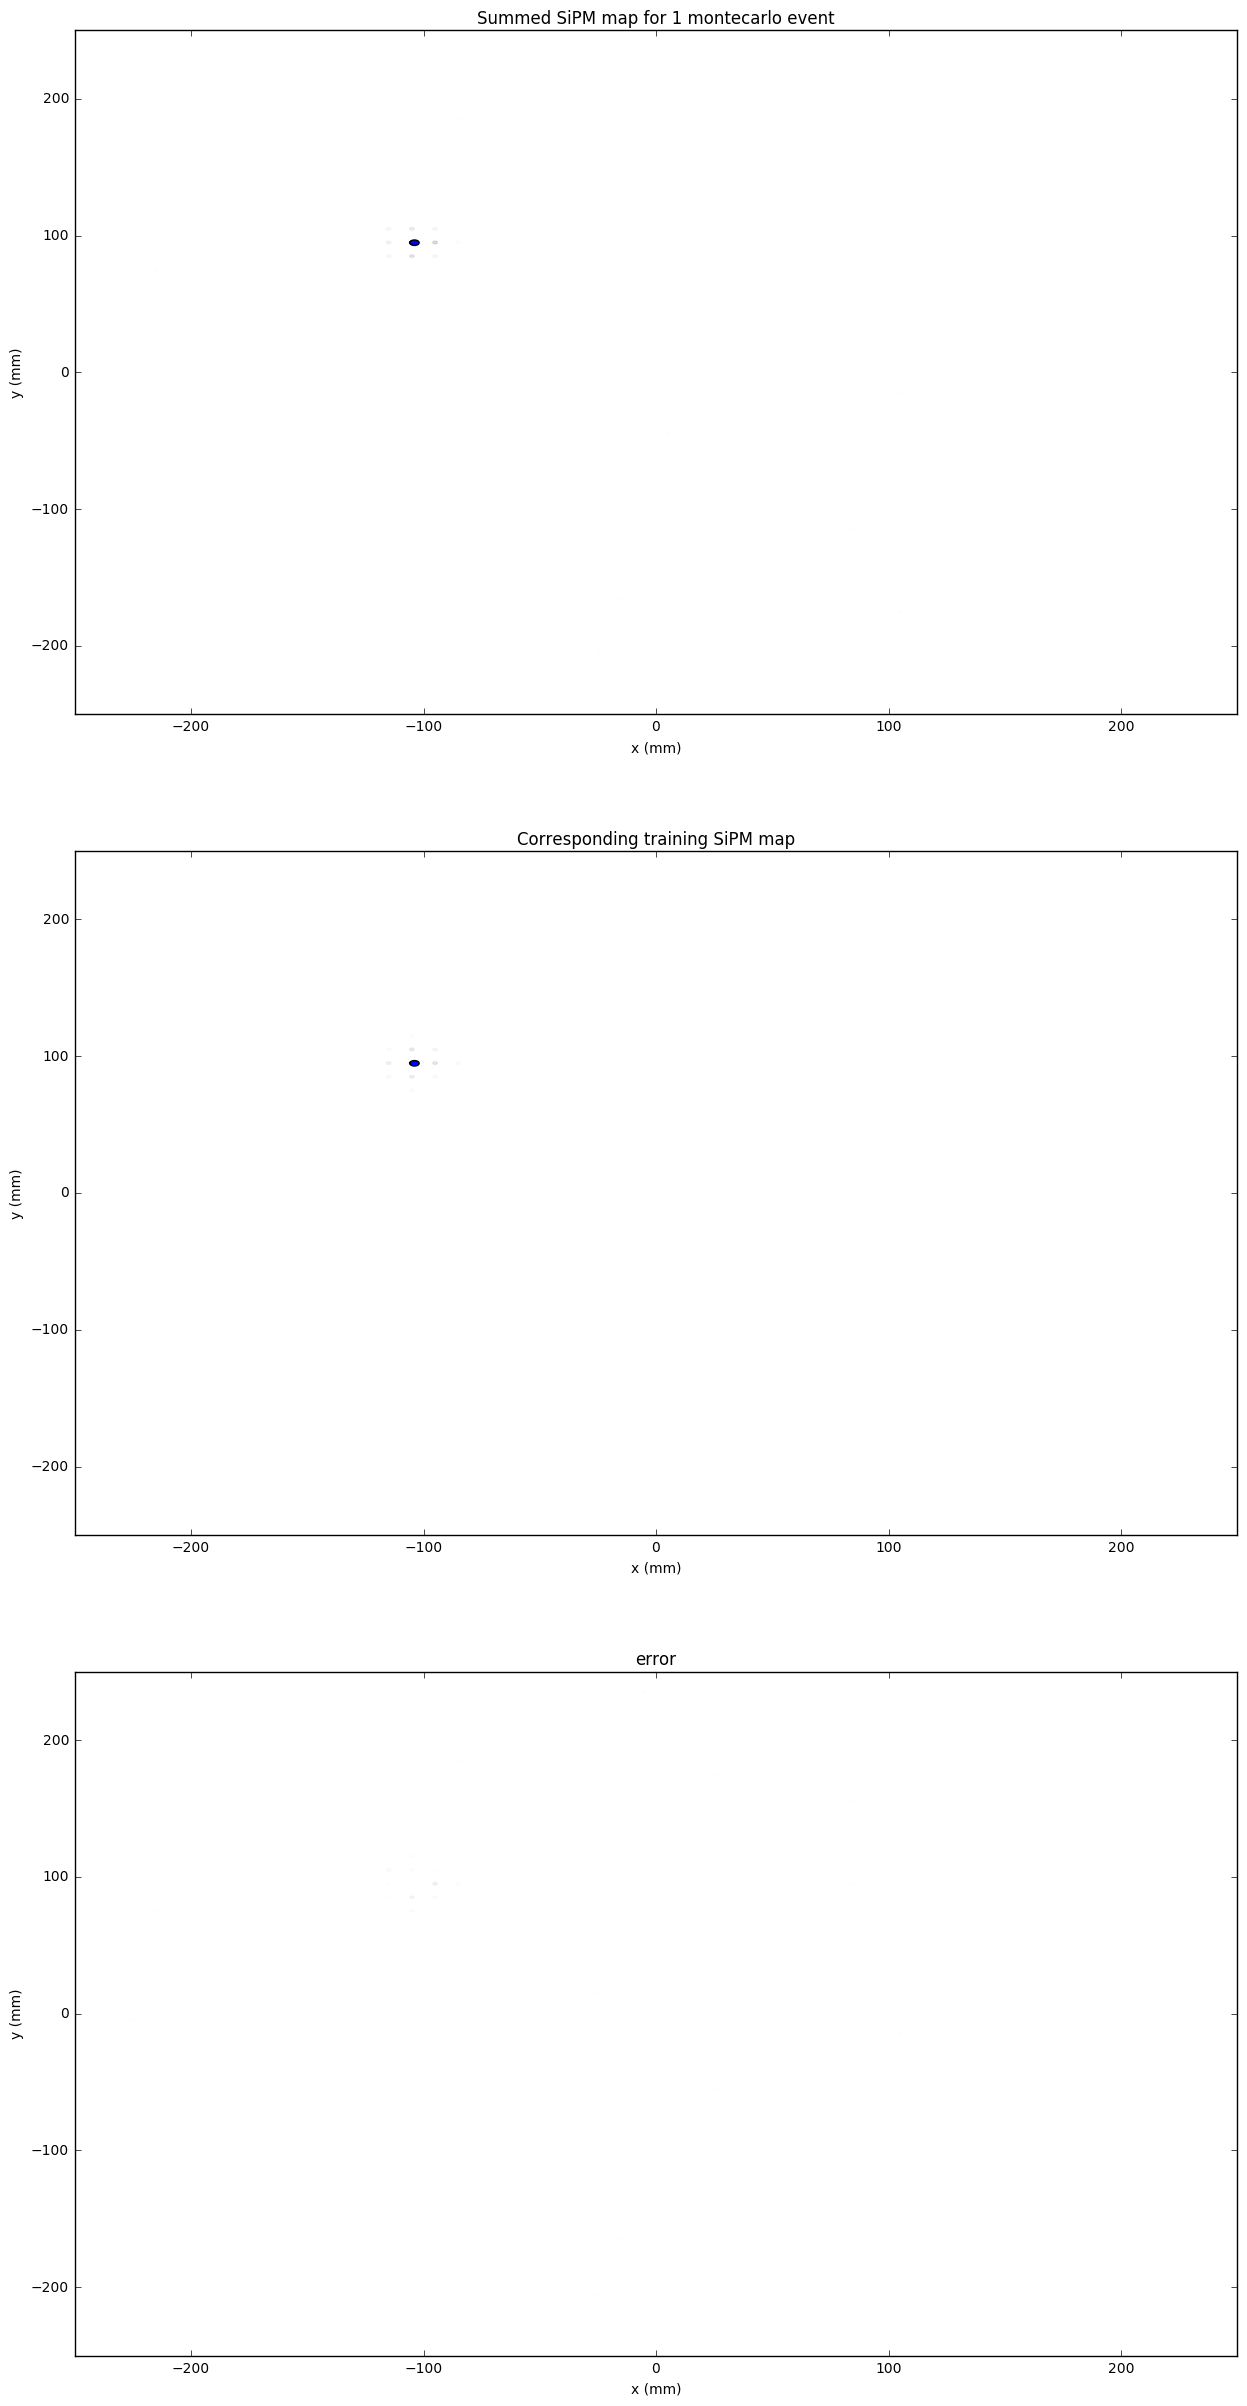

In [6]:
if Compare_with_MC:

    # Load MC data
    monte = tb.open_file('Nodiff_kr_test_1000.h', 'r')
    monte_maps = np.array(monte.root.maps)
    monte_coords = np.array(monte.root.coords)

    # Plot and compare a MC map with a training map
    ex_evt = 90
    ex_training_map = np.zeros((48,48), dtype=np.float32)
    ex_coords = np.int32(np.round(monte_coords[ex_evt]))
    
    i = np.where((grid == ex_coords).all(axis=1))[0]
    sli_pos = pos[i]
    sli_idx = np.array((sli_pos + 235) / 10, dtype=np.int32)
    sli_probs = probs[i]
    for xidx,yidx,probj in zip(sli_idx[:,0], sli_idx[:,1], sli_probs): 
        if xidx != -977: 
            ex_training_map[xidx,yidx] = np.random.poisson(probj*1.9e6)
    
    #ex_training_map = np.random.poisson(ex_training_map*1.9e6)
    
    fig = plt.figure();
    fig.set_figheight(30.0)
    fig.set_figwidth(15.0)

    xarr = monte_maps[ex_evt]
    yarr = monte_coords[ex_evt,:2]

    ax1 = fig.add_subplot(311);
    ax1.axis([-250, 250, -250, 250]);
    NEW_SiPM_map_plot(xarr,yarr)
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");
    plt.title("Summed SiPM map for 1 montecarlo event")

    ax1 = fig.add_subplot(312);
    ax1.axis([-250, 250, -250, 250]);
    NEW_SiPM_map_plot(ex_training_map, yarr)
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");
    plt.title("Corresponding training SiPM map")

    ax1 = fig.add_subplot(313);
    ax1.axis([-250, 250, -250, 250]);
    NEW_SiPM_map_plot(abs(ex_training_map/np.max(ex_training_map) - xarr/np.max(xarr)), 
                      yarr, plot_truth=False, normalize=False)
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");
    plt.title("error")
    plt.show()


Generate SiPM maps

In [7]:
def populate_SiPM_maps(coords):
    """
    Takes a set of labels as input, populates corresponding maps
    """
    nevts = len(coords)
    maps = np.zeros((nevts, 48, 48), dtype=np.float32)

    # for each time slice: collect non zero sipm responses, populate maps 
    for z,xy in enumerate(coords):

        # collect non zero sipm responses
        i         = np.where((grid == xy).all(axis=1))[0]
        sli_pos   = pos[i]
        sli_idx   = np.array((sli_pos + 235) / 10, dtype=np.int)
        sli_probs = probs[i]
        #testmaps[z,sli_idx[:,0],sli_idx[:,1]] = sli_probs

        # populate sipm maps for this time slice
        for xidx,yidx,probj in zip(sli_idx[:, 0], sli_idx[:, 1], sli_probs): 
            if xidx != -977: maps[z,xidx,yidx] = np.random.poisson(probj * 1.9e6)
        if (z + 1) % 1000 == 0: print(str(z / float(nevts)) + ' complete...')
             
    #return np.random.poisson(maps*1.9e6)
    return maps

Save the coordinate of the randomly generated hits, and their SiPM maps

In [8]:
if generate_training_data:
    
    # Generate random events in EL plane
    nevts   = 100000
    EL_rad  = 198
    N_ELpts = 1

    # Generate random events in EL plane
    polar_coords = gen_polar_hits(nevts, N_ELpts, EL_rad)
    coords = cartesian_convert(polar_coords[:, :N_ELpts],
                               polar_coords[:, N_ELpts:], N_ELpts)

    # Round for easy extraction from the light table
    rcoords = np.array(np.round(coords), dtype=np.int)

    maps = populate_SiPM_maps(rcoords)

    f = tb.open_file('new_light_100k.h', 'w')
    filters = tb.Filters(complib='blosc', complevel=9, shuffle=False)

    atom    = tb.Atom.from_dtype(maps.dtype)
    tmaps   = f.create_earray(f.root, 'maps',   atom, (0,48,48), filters=filters) 

    atom    = tb.Atom.from_dtype(coords.dtype)
    tcoords = f.create_earray(f.root, 'coords', atom, (0,2),     filters=filters)

    for i in range(nevts):
        tmaps.append([maps[i]])
        tcoords.append([coords[i]])

    print(f)
    f.close()

0.00999 complete...
0.01999 complete...
0.02999 complete...
0.03999 complete...
0.04999 complete...
0.05999 complete...
0.06999 complete...
0.07999 complete...
0.08999 complete...
0.09999 complete...
0.10999 complete...
0.11999 complete...
0.12999 complete...
0.13999 complete...
0.14999 complete...
0.15999 complete...
0.16999 complete...
0.17999 complete...
0.18999 complete...
0.19999 complete...
0.20999 complete...
0.21999 complete...
0.22999 complete...
0.23999 complete...
0.24999 complete...
0.25999 complete...
0.26999 complete...
0.27999 complete...
0.28999 complete...
0.29999 complete...
0.30999 complete...
0.31999 complete...
0.32999 complete...
0.33999 complete...
0.34999 complete...
0.35999 complete...
0.36999 complete...
0.37999 complete...
0.38999 complete...
0.39999 complete...
0.40999 complete...
0.41999 complete...
0.42999 complete...
0.43999 complete...
0.44999 complete...
0.45999 complete...
0.46999 complete...
0.47999 complete...
0.48999 complete...
0.49999 complete...


Compare the error of saved NN reconstructing MC maps and training maps with the same true labels

In [9]:
if Compare_NN_predictions:
    from keras.models import load_model
    import scipy.stats
    
    def prep_dnn_input(x, y, Thresh=-1):
        """
        Normalize maps and labels for DNN input
        """
        if Thresh != -1:
            xp = stats.threshold(x, Thresh)
        else:
            xp = x
            
        xp = np.reshape(xp, (len(xp), 1, 48 ,48)) / np.max(xp)
        yp = (y / 198.0 + 1) / 2.0
        return [xp, yp]
    
    
    def compute_error(pred, real):
        """
        computes error for each prediction
        """
        return np.sqrt((pred[:,0] - real[:,0]) ** 2 + (pred[:,1] - real[:,1]) ** 2)
    
    
    monte_xy = monte_coords[:, :2]
    
    # Generate training maps using the same coords as in the montecarlo file
    training_maps = populate_SiPM_maps(np.round(monte_xy))
    
    # Normalize datasets for DNN
    [x_tr, y_MC] = prep_dnn_input(training_maps, monte_xy) #  Training
    [x_MC, y_MC] = prep_dnn_input(monte_maps, monte_xy)    #  MC
    
    # Compute absolute difference in maps:
    map_diff = np.sum(np.sum(np.reshape(abs(x_tr - x_MC), (len(x_tr), 48, 48)), axis=1), axis=1)
    
    # Load NN model
    model = load_model('NN_models/lay4_light_tab.h')    
    
    # Get NN predictions for training maps and MC maps
    training_predictions = (model.predict(x_tr) * 2 - 1) * 198
    monte_predictions = (model.predict(x_MC) * 2 - 1) * 198
    
    # Compute the error of each
    training_error = compute_error(training_predictions, monte_xy)
    monte_error = compute_error(monte_predictions, monte_xy)
    
    print('Mean training error: ' + str(np.mean(training_error))) 
    print('Mean montecarlo error: ' + str(np.mean(monte_error)))   
    
    # Plot some stuff
    plt.scatter(map_diff, monte_error)
    plt.xlabel('Summed absolute difference in SiPM responses')
    plt.ylabel('Montecarlo dnn reconstruction error')
    plt.grid(True)
    plt.show()
    
    plt.scatter(training_error, monte_error)
    plt.xlabel('training error')
    plt.ylabel('montecarlo error')
    plt.grid(True)
    plt.show()
    